In [1]:
import os
os.chdir('./yolov5')

In [2]:
from yolov5.utils.dataloaders import LoadImages
from yolov5.utils.general import non_max_suppression, scale_boxes, xyxy2xywh
from yolov5.utils.augmentations import letterbox
from yolov5.models.experimental import attempt_load
import torch
import cv2
import numpy as np
from typing import Union, List
import matplotlib.pyplot as plt
def load_img(img_path: str):
    return cv2.imread(img_path)

def load_binary_img(img_path: str):
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Binarize
    _ , im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY)
    return im

def normalize_coord(coord: List[Union[int, float]], 
                    w: int, 
                    h: int, 
                    expand = 0):
    x1, y1, x2, y2 = [int(c) for c in coord]
    expand = int(expand)
    x1 = max(x1 - expand, 0)
    x2 = min(x2 + expand, int(w))
    y1 = max(y1 - expand, 0)
    y2 = min(y2 + expand, int(h))

    return [x1, y1, x2, y2]


class Yolov5_Predictor(object):
    def __init__(self, weight_path:str,
                        iou_thres = 0.6,
                        conf_thres = 0.1,
                        max_det = 1000,
                        img_size=(960, 960),
                        device='cpu') -> None:
        self.device = torch.device(device) if isinstance(device, str) else device

        # Initialize Model
        self.model = attempt_load(weights=weight_path, device=self.device, inplace=True, fuse=True)
        self.model = self.model.to(self.device)
        self.stride = max(int(self.model.stride.max()), 32)
        self.classes_names = self.model.names
        
        # Setting
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.max_det = max_det
        self.img_size = img_size
        self.crop_expand = {'scratch':20,
                            'powder_uneven':80,
                            'powder_uncover':80,}
    def predict(self, im0: Union[str, np.ndarray]):
        if isinstance(im0, str):
            im0 = load_img(im0)
        # im0 = cv2.imread(img_path)
        # Processing image
        im = letterbox(im0, self.img_size, stride=self.stride)[0]  # padded resize
        im = im.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
        im = np.ascontiguousarray(im)
        im = torch.from_numpy(im).to(self.device)
        im = im.unsqueeze(dim=0) # add batch_size dimension
        im = im.float()  # uint8 to fp32
        im /= 255
        # Predict
        pred = self.model(im)
        # Process predictions
        pred = non_max_suppression(pred, self.conf_thres, self.iou_thres, max_det=self.max_det)
        det = pred[0]
        if len(det):
            bboxs = []
            det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]
            for *xyxy, conf, cls in reversed(det):
                # xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                bboxs.append([int(cls), *xyxy]) # [cls, x1, y1, x2, y2]
            return bboxs
        else:
            return None

    def set_crop_expand(self, crop_expand:dict):
        if set(crop_expand.keys()) != set(self.classes_names):
            raise ValueError("The names of class in crop_expand should match the names of class in model")
        self.crop_expand = crop_expand

    def predict_crop(self, img_path:str, mask_path:str= None):
        im = load_img(img_path)
        im_h, im_w, c = im.shape
        bboxes = self.predict(im)


        crop_imgs = []
        box_infos = []

        if bboxes != None:
            total_area = im_h * im_w
            new_mask = np.zeros((im_h, im_w), dtype=np.uint8)
            for box in bboxes:
                cls_idx, x1, y1, x2, y2 = box
                cls_name = self.classes_names[cls_idx]
                expand = self.crop_expand[cls_name]
                # If the bbox is too small, then expand most.
                area = ((x2 - x1) * (y2 - y1)) / total_area

                cur_expand = expand * 2 if area <= 0.015 else expand
                x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h, expand=cur_expand)
                new_mask[y1:y2, x1:x2] = 255
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask, ltype=cv2.CV_16U)
            if num_labels >= 1:
               
                if mask_path != None:
                    mask = load_binary_img(mask_path)
                    crop_masks = []
                # Converted [x1, y1, w, h] to [x1, y1, x2, y2]
                stats[:,2] += stats[:,0]
                stats[:,3] += stats[:,1]

                # gray_img = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                # gray_img = cv2.equalizeHist(gray_img)
                # im = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

                for i in range(1, num_labels):
                    x1, y1, x2, y2, area = stats[i]
                    x1, y1, x2, y2 = normalize_coord([x1, y1, x2, y2], im_w, im_h)
                    box_w, box_h = (x2 - x1), (y2 - y1)
                    # Crop origin image and mask image
                    crop_im = im[y1:y2, x1:x2, ...]
                    crop_imgs.append(crop_im)
                    if mask_path != None:
                        crop_mask = mask[y1:y2, x1:x2]
                        crop_masks.append(crop_mask)
                    box_info = (box_w, box_h, x1, y1, x2, y2)
                    box_infos.append(box_info)
        
        if mask_path != None:
            return crop_imgs, crop_masks, box_infos
        else:
            return crop_imgs, box_infos

c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
img_size = (960, 960)
weight_path = './runs/train/[2022-12-29-1549]960_bs16_med_E400/weights/best.pt'
iou_thres = 0.6
conf_thres = 0.1
predictor = Yolov5_Predictor(weight_path= weight_path,
                            iou_thres=iou_thres,
                            conf_thres=conf_thres,
                            img_size=img_size)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs


In [4]:
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

split = 'Train'
input_root = '../data/yolov5/'
output_root = '../data/unet/'

resize_size = (320, 320)
for split in ['Train', 'Val']:
    input_split_folder = join(input_root, split)
    output_split_folder = join(output_root, split)

    input_img_folder = join(input_split_folder, 'images')
    input_mask_folder = join(input_split_folder, 'masks')

    os.makedirs(join(output_split_folder, 'images'), exist_ok=True)
    os.makedirs(join(output_split_folder, 'masks'), exist_ok=True)
    os.makedirs(join(output_split_folder, 'labels'), exist_ok=True)
    for img_name in os.listdir(input_img_folder):
        raw_name = img_name.split('.')[0]
        if 'scratch' not in raw_name:
            continue
        img_path = join(input_img_folder, img_name)
        mask_path = join(input_mask_folder, img_name)

        crop_imgs, crop_masks, box_infos = predictor.predict_crop(img_path, mask_path)
        recover_lines = []
        # Write
        for crop_idx, (img, mask, box) in enumerate(zip(crop_imgs, crop_masks, box_infos)):
            # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # gray_img = cv2.equalizeHist(gray_img)
            # img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
            img = cv2.resize(img, resize_size)
            mask = cv2.resize(mask, resize_size, interpolation=cv2.INTER_NEAREST)

            new_name = '{}_{}.png'.format(raw_name, crop_idx)

            cv2.imwrite(join(output_split_folder, 'images', new_name), img)
            cv2.imwrite(join(output_split_folder, 'masks', new_name), mask)
            # (box_w, box_h, x1, y1, x2, y2) for recover mask
            box_line = ','.join([str(c) for c in box])
            recover_lines.append(new_name + ',' + box_line + '\n')
        with open(join(output_split_folder, 'labels', '{}.txt'.format(raw_name)), 'w') as f:
            f.writelines(recover_lines)

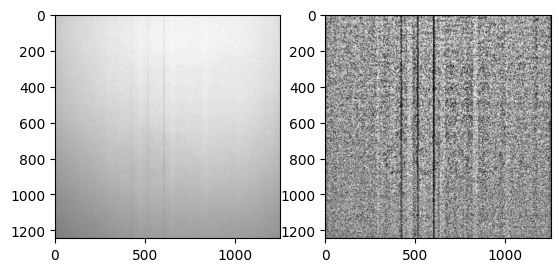

In [24]:
import cv2
import matplotlib.pyplot as plt
img_path = './data/yolov5/Train/images/scratch_0.png'
origin_im = cv2.imread(img_path)
gray_img = cv2.cvtColor(origin_im, cv2.COLOR_BGR2GRAY)

# gray_img = cv2.GaussianBlur(gray_img, (5,5), 0, 0)
clipLimit = 20
tileGridSize = (30, 30)
clahe = cv2.createCLAHE(clipLimit, tileGridSize)
qual_im = clahe.apply(gray_img)

qual_im = cv2.cvtColor(qual_im, cv2.COLOR_GRAY2BGR)

ax = plt.subplot(1,2,1)
ax.imshow(origin_im)

ax = plt.subplot(1,2,2)
ax.imshow(qual_im)

In [8]:
qual_im.shape

(1244, 1254)

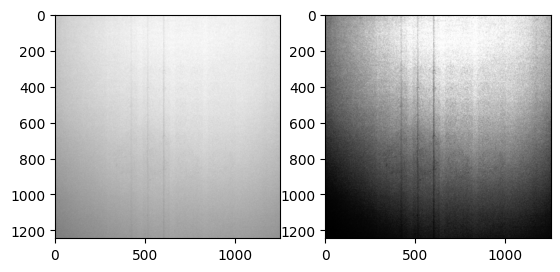

In [26]:
import cv2
import matplotlib.pyplot as plt
img_path = './data/yolov5/Train/images/scratch_0.png'
origin_im = cv2.imread(img_path)

gray_img = cv2.GaussianBlur(gray_img, (3,3), 0, 0)
gray_img = cv2.cvtColor(origin_im, cv2.COLOR_BGR2GRAY)
gray_img = cv2.equalizeHist(gray_img)

qual_im = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)

ax = plt.subplot(1,2,1)
ax.imshow(origin_im)

ax = plt.subplot(1,2,2)
ax.imshow(qual_im)
# img = cv2.resize(img, resize_size)

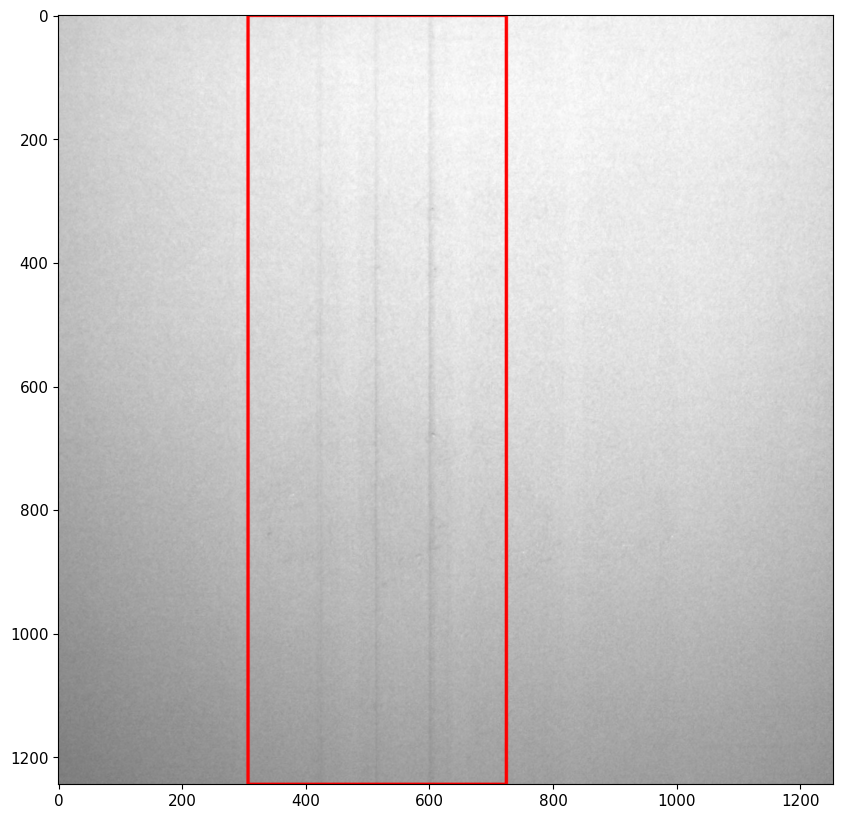

In [13]:
%matplotlib inline
resize_size = (320, 320)
img_path = '../data/yolov5/Train/images/scratch_0.png'
mask_path ='../data/yolov5/Train/masks/scratch_0.png'
crop_imgs, crop_masks, box_infos = predictor.predict_crop(img_path, mask_path)
recover_lines = []
# Write
plt.figure(figsize=(10,10))

origin_im = cv2.imread(img_path)


for crop_idx, (img, mask, box) in enumerate(zip(crop_imgs, crop_masks, box_infos)):
    box_w, box_h, x1, y1, x2, y2 = [int(c) for c in box]
    cv2.rectangle(origin_im , (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    # cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    plt.imshow(origin_im)
    img = cv2.resize(img, resize_size)
    mask = cv2.resize(mask, resize_size, interpolation=cv2.INTER_NEAREST)

    # new_name = '{}_{}.png'.format(raw_name, crop_idx)
    # cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    
    # ax = plt.subplot(1,3,1)
    # ax.imshow(img)
    # ax.axis(False)

    # ax = plt.subplot(1,3,2)
    # ax.imshow(mask)
    # ax.axis(False)

    # ax = plt.subplot(1,3,2)
    # ax.imshow(resized_predict_mask)
    # ax.axis(False)
        
plt.show()


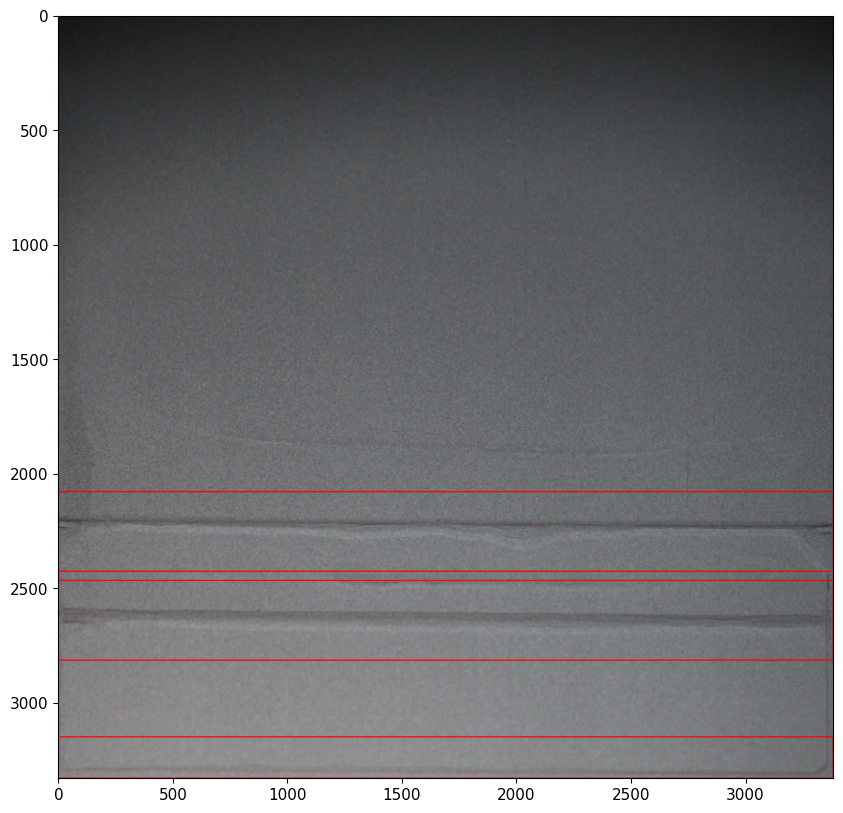

In [14]:
%matplotlib inline
resize_size = (320, 320)
img_path = '../data/yolov5/Train/images/powder_uneven_1.png'
mask_path ='../data/yolov5/Train/masks/powder_uneven_1.png'
crop_imgs, crop_masks, box_infos = predictor.predict_crop(img_path, mask_path)
recover_lines = []
# Write
plt.figure(figsize=(10,10))

origin_im = cv2.imread(img_path)


for crop_idx, (img, mask, box) in enumerate(zip(crop_imgs, crop_masks, box_infos)):
    box_w, box_h, x1, y1, x2, y2 = [int(c) for c in box]
    cv2.rectangle(origin_im , (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    # cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    plt.imshow(origin_im)
    img = cv2.resize(img, resize_size)
    mask = cv2.resize(mask, resize_size, interpolation=cv2.INTER_NEAREST)

    # new_name = '{}_{}.png'.format(raw_name, crop_idx)
    # cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
    
    # ax = plt.subplot(1,3,1)
    # ax.imshow(img)
    # ax.axis(False)

    # ax = plt.subplot(1,3,2)
    # ax.imshow(mask)
    # ax.axis(False)

    # ax = plt.subplot(1,3,2)
    # ax.imshow(resized_predict_mask)
    # ax.axis(False)
        
plt.show()


In [12]:
box

(418, 1244, 307, 0, 725, 1244)

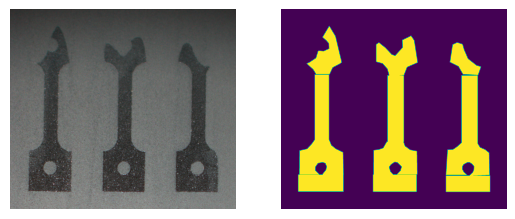

In [12]:
from os.path import join
from tqdm import tqdm
start_idx = 5
end_idx = start_idx + 3

category = predictor.classes_names[2]

if category == 'scratch':
    expand = 100
else:
    expand = 80

split = 'Train'
output_root = '../data/stage2/{}/images/'.format(split)
os.makedirs(output_root, exist_ok=True)

unet_img_root = '../data/unet/{}/images/'.format(split)
os.makedirs(unet_img_root, exist_ok=True)
unet_mask_root = '../data/unet/{}/masks/'.format(split)
os.makedirs(unet_mask_root, exist_ok=True)
# for i in range(start_idx, end_idx):
for i in tqdm(range(100)):
    file_name = '{}_{}.png'.format(category, i)
    img_path = '../data/yolov5/{}/images/'.format(split) + file_name
    result = predictor.predict(img_path)

    mask_path = '../data/yolov5/{}/masks/'.format(split) + file_name
    im = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    im_h, im_w, c = im.shape
    new_mask = np.zeros((im_h, im_w, c), dtype=np.uint8)
    ratios = []
    total_area = im_h * im_w
    for box in result:
        cls_idx, x1, y1, x2, y2 = box
        ratio = (x2 - x1) / (y2 - y1)
        if ratio < 1:
            ratio = 1 / ratio
        ratios.append(ratio)

        area = ((x2 - x1) * (y2 - y1)) / total_area
        if area <= 0.015:
            cur_expand = expand * 2
        else:
            cur_expand = expand
        x1 = max(int(x1) - cur_expand, 0)
        x2 = min(int(x2) + cur_expand, im_w)
        y1 = max(int(y1) - cur_expand, 0)
        y2 = min(int(y2) + cur_expand, im_h)

        # crop = im[int(y1):int(y2), int(x1):int(x2), :]
        cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
        cv2.rectangle(mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
        new_mask[y1 : y2, x1 : x2, ...] = 255

    # print(np.mean(ratios))
    new_size = (im_h // 6, im_w // 6)
    im = cv2.resize(im, new_size)
    mask = cv2.resize(mask, new_size)
    # new_mask = cv2.resize(new_mask, new_size)
    # cv2.imshow('image', cv2.resize(new_mask, new_size))
    # cv2.waitKey(0)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_mask[...,0], connectivity=8, ltype=cv2.CV_16U)
    # print(stats)

    if num_labels >= 1:
        stats[:,2] += stats[:,0]
        stats[:,3] += stats[:,1]
        new_im = cv2.imread(img_path)
        new_mask = cv2.imread(mask_path, 0)
        unique = np.unique(new_mask)
        ret, new_mask = cv2.threshold(new_mask, unique[1] - 1, 255, cv2.THRESH_BINARY)

        raw_name = file_name.split('.')[0]
        for i in range(1, num_labels):
            new_name = raw_name + '_{}.png'.format(i - 1)
            x1, y1, x2, y2, area = stats[i]
            x1 = max(int(x1), 0)
            x2 = min(int(x2), im_w)
            y1 = max(int(y1), 0)
            y2 = min(int(y2), im_h)
            cv2.imwrite(join(unet_img_root, new_name), new_im[y1:y2, x1:x2, :])
            cv2.imwrite(join(unet_mask_root, new_name), new_mask[y1:y2, x1:x2])

    # if num_labels >= 1:
    #     stats[:,2] += stats[:,0]
    #     stats[:,3] += stats[:,1]
        # new_im = cv2.imread(img_path)
        # new_mask = cv2.imread(mask_path)
        new_mask = cv2.imread(mask_path)
        for i in range(1, num_labels):
            x1, y1, x2, y2, area = stats[i]
            x1 = max(int(x1), 0)
            x2 = min(int(x2), im_w)
            y1 = max(int(y1), 0)
            y2 = min(int(y2), im_h)
            cv2.rectangle(new_im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)
            cv2.rectangle(new_mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 4, cv2.LINE_AA)

        new_im = cv2.resize(new_im, new_size)

        new_mask = cv2.resize(new_mask, new_size)

        cv2.imwrite(os.path.join(output_root, file_name), cv2.vconcat([cv2.hconcat([mask, im]), cv2.hconcat([new_im, new_mask])]))
    # cv2.imshow('image', cv2.vconcat([cv2.hconcat([mask, im]), cv2.hconcat([new_im, new_mask])]))
    # cv2.waitKey(0)

100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


In [5]:
import os
import cv2
from os.path import join

class_names = ['powder_uncover', 'powder_uneven', 'scratch']
# class_names = ['powder_uncover']
data_root = './data/unet'
new_data_root = './data/unet_resized'


resize_size = (320, 320)
# with Pool(6) as p:
for data_split in ['Train', 'Val']:
    split_folder = join(data_root, data_split)
    new_split_folder = join(new_data_root, data_split)

    img_folder = join(split_folder, 'images')
    mask_folder = join(split_folder, 'masks')

    new_img_folder = join(new_split_folder, 'images')
    os.makedirs(new_img_folder, exist_ok=True)
    new_mask_folder = join(new_split_folder, 'masks')
    os.makedirs(new_mask_folder, exist_ok=True)

    for f in os.listdir(img_folder):
        if f.split('_')[0] == 'powder':
            class_name = '_'.join(f.split('_')[:2])
        else:
            class_name = f.split('_')[0]
        cls_idx = class_names.index(class_name)
        img_path = join(img_folder, f)

        im = cv2.imread(img_path)
        im = cv2.resize(im, resize_size)
        cv2.imwrite(join(new_img_folder, f), im)

        mask_path = join(mask_folder, f)

        mask_im = cv2.imread(mask_path)
        mask_im = cv2.resize(mask_im, resize_size, interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(join(new_mask_folder, f), mask_im)
    # label_folder = join(split_folder, cls_name, 'label')
    # mask_folder = join(split_folder, cls_name, 'mask')

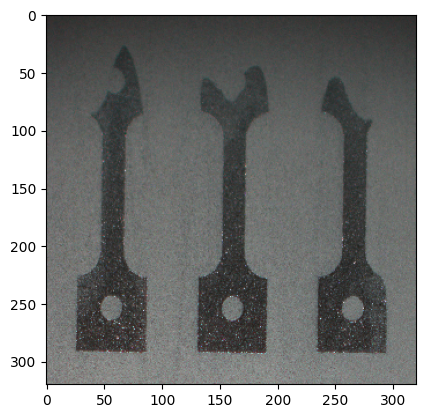

In [16]:
import matplotlib.pyplot as plt

plt.imshow(im)

In [12]:
im.shape

(1857, 2095, 3)